# Домашнее задание

1. Добиться хорошего результата от модели, собранной на занятии (5 угаданныx картинок из 8 предложенных). Варианты изменений:
- изменение слоёв и их количества;
- изменение метода оптимизации;
- изменение процесса обучения;
- *преобразование данных transform

2. *Переписать данный туториал на PyTorch: https://www.tensorflow.org/tutorials/quickstart/beginner?hl=ru

Напишим небольшую полносвязную сеть на торче.

In [2]:
import torch
import numpy as np
import torch.nn.functional as F
from torch import nn
import torchvision

# Посмотрим на более сложную архитектуру

In [3]:
import matplotlib.pyplot as plt

# %pylab inline

In [4]:
from torch import optim

In [5]:
import torchvision.transforms as transforms

In [6]:
train_dataset = torchvision.datasets.CIFAR10(root='data/',
                                             train=True,  
                                             transform=transforms.ToTensor(), 
                                             download=True)


image, label = train_dataset[0]
print(image.size())
print(label)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
torch.Size([3, 32, 32])
6


In [242]:
image.permute(1, 2, 0).shape

torch.Size([32, 32, 3])

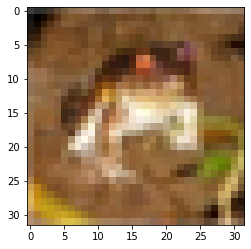

In [243]:
plt.imshow(image.permute(1, 2, 0).numpy());

In [7]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)

In [8]:
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8,
                                          shuffle=False)

Files already downloaded and verified


In [9]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [11]:
import torch.nn.functional as F

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [248]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 4 * hidden_dim)
        self.fc2 = nn.Linear(4 * hidden_dim, 2 * hidden_dim)
        self.fc3 = nn.Linear(2 * hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        x = F.leaky_relu(x)
        x = self.fc4(x)
        return x
    
    def predict(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        x = F.leaky_relu(x)
        x = self.fc4(x)
        x = F.softmax(x)
        return x


net = Net(3072, 100, 10)
net.to(device)
net.train()

Net(
  (fc1): Linear(in_features=3072, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
)

**Считаем при 5 эпохах и методе оптимизации SGD**

In [249]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.0)

In [250]:
num_epochs = 5
losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_items = 0.0


    for i, data in enumerate(train_loader):
        # inputs, labels = data[0], data[1]
        inputs, labels = data[0].to(device), data[1].to(device)


        # Обнуляем градиент
        optimizer.zero_grad()
        # Делаем предсказание
        outputs = net(inputs)
        # Рассчитываем лосс-функцию
        loss = criterion(outputs, labels)
        # Делаем шаг назад по лоссу
        loss.backward()
        # Делаем шаг нашего оптимайзера
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        if (i + 1) == (len(train_loader)):
            losses.append(running_loss / running_items)
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}')            
            running_loss, running_items = 0.0, 0.0  

print('Training is finished!')

Epoch [1/5]. Step [1/782]. Loss: 0.036
Epoch [1/5]. Step [301/782]. Loss: 0.036
Epoch [1/5]. Step [601/782]. Loss: 0.035
Epoch [2/5]. Step [1/782]. Loss: 0.032
Epoch [2/5]. Step [301/782]. Loss: 0.032
Epoch [2/5]. Step [601/782]. Loss: 0.031
Epoch [3/5]. Step [1/782]. Loss: 0.031
Epoch [3/5]. Step [301/782]. Loss: 0.030
Epoch [3/5]. Step [601/782]. Loss: 0.030
Epoch [4/5]. Step [1/782]. Loss: 0.030
Epoch [4/5]. Step [301/782]. Loss: 0.029
Epoch [4/5]. Step [601/782]. Loss: 0.029
Epoch [5/5]. Step [1/782]. Loss: 0.027
Epoch [5/5]. Step [301/782]. Loss: 0.028
Epoch [5/5]. Step [601/782]. Loss: 0.028
Training is finished!


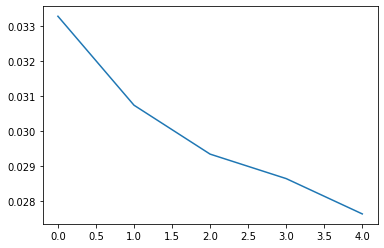

In [251]:
plt.plot(losses)
plt.show()


In [252]:
data_iter = iter(test_loader)
images, labels = next(data_iter)

GroundTruth:  cat ship ship plane frog frog car frog


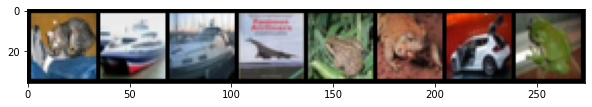

In [253]:
net.eval()
images = images.to(device)
outputs = net(images)
imgs = torchvision.utils.make_grid(images)
plt.figure(figsize=(10, 5))
plt.imshow(imgs.permute(1, 2, 0).cpu().numpy())
print('GroundTruth: ', ' '.join(classes[labels[j]] for j in range(len(labels))))

In [254]:
_, predicted = torch.max(outputs, 1)
gt = np.array([classes[labels[j]] for j in range(len(labels))])
pred = np.array([classes[predicted[j]] for j in range(len(labels))])

print(gt)
print(pred)
print(f'Accuracy is {(gt == pred).sum() / len(gt)}')

['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['dog' 'car' 'ship' 'ship' 'frog' 'frog' 'dog' 'deer']
Accuracy is 0.375


**Считаем при 30 эпохах и методе оптимизации SGD**

In [255]:
net = Net(3072, 100, 10)
net.to(device)
net.train()

Net(
  (fc1): Linear(in_features=3072, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
)

In [256]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.0)

In [257]:
num_epochs = 30
losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_items = 0.0


    for i, data in enumerate(train_loader):
        # inputs, labels = data[0], data[1]
        inputs, labels = data[0].to(device), data[1].to(device)


        # Обнуляем градиент
        optimizer.zero_grad()
        # Делаем предсказание
        outputs = net(inputs)
        # Рассчитываем лосс-функцию
        loss = criterion(outputs, labels)
        # Делаем шаг назад по лоссу
        loss.backward()
        # Делаем шаг нашего оптимайзера
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        if (i + 1) == (len(train_loader)):
            losses.append(running_loss / running_items)
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}')            
            running_loss, running_items = 0.0, 0.0  

print('Training is finished!')

Epoch [1/30]. Step [1/782]. Loss: 0.036
Epoch [1/30]. Step [301/782]. Loss: 0.036
Epoch [1/30]. Step [601/782]. Loss: 0.035
Epoch [2/30]. Step [1/782]. Loss: 0.033
Epoch [2/30]. Step [301/782]. Loss: 0.032
Epoch [2/30]. Step [601/782]. Loss: 0.031
Epoch [3/30]. Step [1/782]. Loss: 0.032
Epoch [3/30]. Step [301/782]. Loss: 0.030
Epoch [3/30]. Step [601/782]. Loss: 0.030
Epoch [4/30]. Step [1/782]. Loss: 0.030
Epoch [4/30]. Step [301/782]. Loss: 0.029
Epoch [4/30]. Step [601/782]. Loss: 0.029
Epoch [5/30]. Step [1/782]. Loss: 0.028
Epoch [5/30]. Step [301/782]. Loss: 0.028
Epoch [5/30]. Step [601/782]. Loss: 0.028
Epoch [6/30]. Step [1/782]. Loss: 0.028
Epoch [6/30]. Step [301/782]. Loss: 0.027
Epoch [6/30]. Step [601/782]. Loss: 0.027
Epoch [7/30]. Step [1/782]. Loss: 0.030
Epoch [7/30]. Step [301/782]. Loss: 0.026
Epoch [7/30]. Step [601/782]. Loss: 0.026
Epoch [8/30]. Step [1/782]. Loss: 0.025
Epoch [8/30]. Step [301/782]. Loss: 0.026
Epoch [8/30]. Step [601/782]. Loss: 0.026
Epoch [9

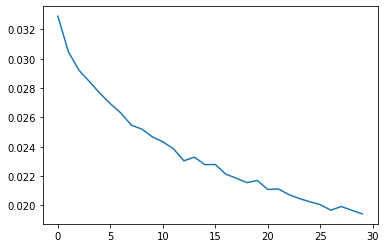

In [258]:
plt.plot(losses)
plt.show()


In [259]:
data_iter = iter(test_loader)
images, labels = next(data_iter)

GroundTruth:  cat ship ship plane frog frog car frog


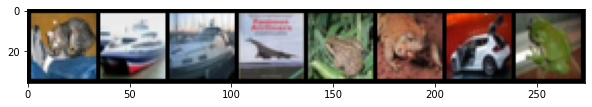

In [260]:
net.eval()
images = images.to(device)
outputs = net(images)
imgs = torchvision.utils.make_grid(images)
plt.figure(figsize=(10, 5))
plt.imshow(imgs.permute(1, 2, 0).cpu().numpy())
print('GroundTruth: ', ' '.join(classes[labels[j]] for j in range(len(labels))))

In [261]:
_, predicted = torch.max(outputs, 1)
gt = np.array([classes[labels[j]] for j in range(len(labels))])
pred = np.array([classes[predicted[j]] for j in range(len(labels))])

print(gt)
print(pred)
print(f'Accuracy is {(gt == pred).sum() / len(gt)}')

['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['cat' 'car' 'car' 'car' 'frog' 'frog' 'car' 'frog']
Accuracy is 0.625


**Считаем при 30 эпохах и методе оптимизации ADAM**

In [262]:
net = Net(3072, 100, 10)
net.to(device)
net.train()

Net(
  (fc1): Linear(in_features=3072, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
)

In [263]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [264]:
num_epochs = 30
losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_items = 0.0


    for i, data in enumerate(train_loader):
        # inputs, labels = data[0], data[1]
        inputs, labels = data[0].to(device), data[1].to(device)


        # Обнуляем градиент
        optimizer.zero_grad()
        # Делаем предсказание
        outputs = net(inputs)
        # Рассчитываем лосс-функцию
        loss = criterion(outputs, labels)
        # Делаем шаг назад по лоссу
        loss.backward()
        # Делаем шаг нашего оптимайзера
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        if (i + 1) == (len(train_loader)):
            losses.append(running_loss / running_items)
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}')            
            running_loss, running_items = 0.0, 0.0  

print('Training is finished!')

Epoch [1/30]. Step [1/782]. Loss: 0.036
Epoch [1/30]. Step [301/782]. Loss: 0.031
Epoch [1/30]. Step [601/782]. Loss: 0.028
Epoch [2/30]. Step [1/782]. Loss: 0.028
Epoch [2/30]. Step [301/782]. Loss: 0.027
Epoch [2/30]. Step [601/782]. Loss: 0.026
Epoch [3/30]. Step [1/782]. Loss: 0.022
Epoch [3/30]. Step [301/782]. Loss: 0.025
Epoch [3/30]. Step [601/782]. Loss: 0.025
Epoch [4/30]. Step [1/782]. Loss: 0.024
Epoch [4/30]. Step [301/782]. Loss: 0.024
Epoch [4/30]. Step [601/782]. Loss: 0.024
Epoch [5/30]. Step [1/782]. Loss: 0.024
Epoch [5/30]. Step [301/782]. Loss: 0.023
Epoch [5/30]. Step [601/782]. Loss: 0.023
Epoch [6/30]. Step [1/782]. Loss: 0.021
Epoch [6/30]. Step [301/782]. Loss: 0.023
Epoch [6/30]. Step [601/782]. Loss: 0.023
Epoch [7/30]. Step [1/782]. Loss: 0.022
Epoch [7/30]. Step [301/782]. Loss: 0.022
Epoch [7/30]. Step [601/782]. Loss: 0.022
Epoch [8/30]. Step [1/782]. Loss: 0.019
Epoch [8/30]. Step [301/782]. Loss: 0.022
Epoch [8/30]. Step [601/782]. Loss: 0.022
Epoch [9

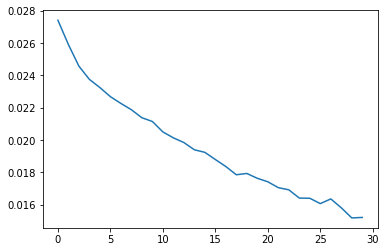

In [265]:
plt.plot(losses)
plt.show()


In [266]:
data_iter = iter(test_loader)
images, labels = next(data_iter)

GroundTruth:  cat ship ship plane frog frog car frog


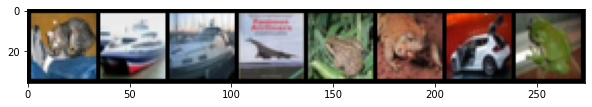

In [267]:
net.eval()
images = images.to(device)
outputs = net(images)
imgs = torchvision.utils.make_grid(images)
plt.figure(figsize=(10, 5))
plt.imshow(imgs.permute(1, 2, 0).cpu().numpy())
print('GroundTruth: ', ' '.join(classes[labels[j]] for j in range(len(labels))))

In [268]:
_, predicted = torch.max(outputs, 1)
gt = np.array([classes[labels[j]] for j in range(len(labels))])
pred = np.array([classes[predicted[j]] for j in range(len(labels))])

print(gt)
print(pred)
print(f'Accuracy is {(gt == pred).sum() / len(gt)}')

['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['cat' 'ship' 'car' 'plane' 'frog' 'frog' 'car' 'frog']
Accuracy is 0.875


**Строим другую модель, считаем при 30 эпохах и методе оптимизации SGD**

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [13]:
net = Net().to(device)
net.train()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.0)

In [15]:
num_epochs = 30
losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_items = 0.0


    for i, data in enumerate(train_loader):
        # inputs, labels = data[0], data[1]
        inputs, labels = data[0].to(device), data[1].to(device)


        # Обнуляем градиент
        optimizer.zero_grad()
        # Делаем предсказание
        outputs = net(inputs)
        # Рассчитываем лосс-функцию
        loss = criterion(outputs, labels)
        # Делаем шаг назад по лоссу
        loss.backward()
        # Делаем шаг нашего оптимайзера
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        if (i + 1) == (len(train_loader)):
            losses.append(running_loss / running_items)
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}')            
            running_loss, running_items = 0.0, 0.0  

print('Training is finished!')

Epoch [1/30]. Step [1/782]. Loss: 0.036
Epoch [1/30]. Step [301/782]. Loss: 0.036
Epoch [1/30]. Step [601/782]. Loss: 0.036
Epoch [2/30]. Step [1/782]. Loss: 0.036
Epoch [2/30]. Step [301/782]. Loss: 0.036
Epoch [2/30]. Step [601/782]. Loss: 0.036
Epoch [3/30]. Step [1/782]. Loss: 0.036
Epoch [3/30]. Step [301/782]. Loss: 0.036
Epoch [3/30]. Step [601/782]. Loss: 0.036
Epoch [4/30]. Step [1/782]. Loss: 0.035
Epoch [4/30]. Step [301/782]. Loss: 0.033
Epoch [4/30]. Step [601/782]. Loss: 0.032
Epoch [5/30]. Step [1/782]. Loss: 0.032
Epoch [5/30]. Step [301/782]. Loss: 0.031
Epoch [5/30]. Step [601/782]. Loss: 0.030
Epoch [6/30]. Step [1/782]. Loss: 0.032
Epoch [6/30]. Step [301/782]. Loss: 0.029
Epoch [6/30]. Step [601/782]. Loss: 0.029
Epoch [7/30]. Step [1/782]. Loss: 0.028
Epoch [7/30]. Step [301/782]. Loss: 0.028
Epoch [7/30]. Step [601/782]. Loss: 0.027
Epoch [8/30]. Step [1/782]. Loss: 0.028
Epoch [8/30]. Step [301/782]. Loss: 0.026
Epoch [8/30]. Step [601/782]. Loss: 0.025
Epoch [9

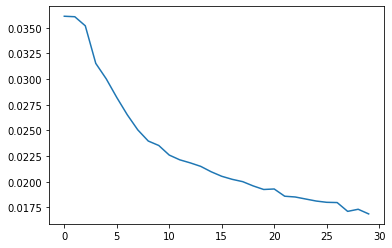

In [16]:
plt.plot(losses)
plt.show()


In [17]:
data_iter = iter(test_loader)
images, labels = next(data_iter)

GroundTruth:  cat ship ship plane frog frog car frog


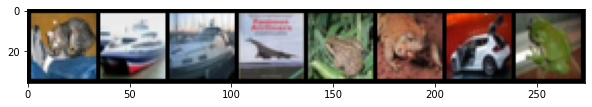

In [18]:
net.eval()
images = images.to(device)
outputs = net(images)
imgs = torchvision.utils.make_grid(images)
plt.figure(figsize=(10, 5))
plt.imshow(imgs.permute(1, 2, 0).cpu().numpy())
print('GroundTruth: ', ' '.join(classes[labels[j]] for j in range(len(labels))))

In [19]:
_, predicted = torch.max(outputs, 1)
gt = np.array([classes[labels[j]] for j in range(len(labels))])
pred = np.array([classes[predicted[j]] for j in range(len(labels))])

print(gt)
print(pred)
print(f'Accuracy is {(gt == pred).sum() / len(gt)}')

['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['cat' 'car' 'ship' 'ship' 'deer' 'frog' 'car' 'frog']
Accuracy is 0.625


2. **Переписать данный туториал на pytorch**: https://www.tensorflow.org/tutorials/quickstart/beginner?hl=ru

In [20]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
     

In [21]:
num_epochs = 5 
num_classes = 10 
batch_size = 100 
learning_rate = 0.001
# Место, куда будет сохранен датасет
DATA_PATH = 'data'
MODEL_STORE_PATH = '.'

In [22]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]) 

train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True) 
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)
     

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [23]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) 
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [25]:
class ConvNet(nn.Module): 
    def __init__(self): 
        super(ConvNet, self).__init__() 
        self.layer1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2), 
                                    nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)) 
        self.layer2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2), 
                                    nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)) 
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)
        
# Определяем последовательность прямого прохода

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [26]:
model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [27]:
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Прямой запуск
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Обратное распространение и оптимизатор
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Отслеживание точности
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))
     

Epoch [1/5], Step [100/600], Loss: 0.2211, Accuracy: 92.00%
Epoch [1/5], Step [200/600], Loss: 0.1576, Accuracy: 95.00%
Epoch [1/5], Step [300/600], Loss: 0.1239, Accuracy: 95.00%
Epoch [1/5], Step [400/600], Loss: 0.1170, Accuracy: 96.00%
Epoch [1/5], Step [500/600], Loss: 0.0196, Accuracy: 99.00%
Epoch [1/5], Step [600/600], Loss: 0.1685, Accuracy: 96.00%
Epoch [2/5], Step [100/600], Loss: 0.0611, Accuracy: 98.00%
Epoch [2/5], Step [200/600], Loss: 0.0606, Accuracy: 98.00%
Epoch [2/5], Step [300/600], Loss: 0.1099, Accuracy: 97.00%
Epoch [2/5], Step [400/600], Loss: 0.0684, Accuracy: 99.00%
Epoch [2/5], Step [500/600], Loss: 0.0710, Accuracy: 95.00%
Epoch [2/5], Step [600/600], Loss: 0.0717, Accuracy: 98.00%
Epoch [3/5], Step [100/600], Loss: 0.1198, Accuracy: 97.00%
Epoch [3/5], Step [200/600], Loss: 0.0074, Accuracy: 100.00%
Epoch [3/5], Step [300/600], Loss: 0.0408, Accuracy: 99.00%
Epoch [3/5], Step [400/600], Loss: 0.0260, Accuracy: 99.00%
Epoch [3/5], Step [500/600], Loss: 0.05

In [28]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

Test Accuracy of the model on the 10000 test images: 98.98 %
